#  Hotel Reviews

### Install and import the packages

In [1]:
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to C:\Users\Tru
[nltk_data]     Projects\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tru
[nltk_data]     Projects\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

%matplotlib inline

### Test the Vader analyzer

In [39]:
#Sentences to try with vader
sentences = ["we stayed here with a team on June 10th & 11th and i have to say we had one of the best stays ever! We travel quite a bit with our sons Lacrosse team but this hotel is one of the best hotels by a landslide! The kids loved the pool and its late hours and we loved having breakfast included for everyone....saves us a ton on $$. Our housekeeper was such a doll and all the rooms i stepped into (other parents & team member rooms) were all spotless. I love that they wash the comforters for every guest THIS SHOULD BE STANDARD FOR EVERY HOTEL. They had a employee contest going on and i wanted to fill out a card but forgot so i figured this was the best way to express our delight! Keep it up, the kids cant wait to come back already"]

In [40]:
#Instantiate an instance to access SentimentIntensityAnalyzer class
sid = SentimentIntensityAnalyzer()

In [41]:
#Vader output
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')

we stayed here with a team on June 10th & 11th and i have to say we had one of the best stays ever! We travel quite a bit with our sons Lacrosse team but this hotel is one of the best hotels by a landslide! The kids loved the pool and its late hours and we loved having breakfast included for everyone....saves us a ton on $$. Our housekeeper was such a doll and all the rooms i stepped into (other parents & team member rooms) were all spotless. I love that they wash the comforters for every guest THIS SHOULD BE STANDARD FOR EVERY HOTEL. They had a employee contest going on and i wanted to fill out a card but forgot so i figured this was the best way to express our delight! Keep it up, the kids cant wait to come back already
compound: 0.9926, neg: 0.0, neu: 0.759, pos: 0.241, 



It can be seen from the previous examples that **Vader sentiment analyzer** does good job in identifying polarity of the sentences and give us **compound** score which is in range of [-1, 1]. As compound is close to +1.0, the sentence has positive words and mood.

## Let's read the .csv data we scrapped from Trip Advisor

In [6]:

hotelDf = pd.read_csv('barrie.csv')
hotelDf.columns=['id','filePath','hotelName','review','ratingScore','groundTruth']

In [7]:
hotelDf.head()

,id,filePath,hotelName,review,ratingScore,groundTruth
0,99145909,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"This is what hotels should be like. Clean, lar...",4,positive
1,97597588,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"The room was beautiful and spacious, but the f...",3,negative
2,96239840,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,I have been staying here off and on most weeks...,5,positive
3,96025643,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"Dear M, I just wanted to write a note of thank...",5,positive
4,95527737,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,Stayed here for two nights in Feb 2011. Great ...,5,positive


In [8]:
# There are unparsed html tags in the hotelnames. We can changed the html tags to ascii equivalents by using the following code.
for i in range(len(hotelDf)):
    hotelname = hotelDf.at[i, 'hotelName']
    hotelname = hotelname.encode("utf-8")
    hotelname = hotelname.decode("ascii", "ignore")
    hotelname = html.unescape(hotelname)
    hotelDf.at[i, 'hotelName'] = hotelname

One thing we can notice here is the groundtruth is categorical variable ('positive', 'negative'). If the rating score is 4 or 5, we say the ground truth is positive, otherwise we say it is negative.

In [9]:
# Instantiate the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [10]:
vaderScores = []
#Assign Vader score to individual review using Vader compound score
for rownum, review in enumerate(hotelDf['review']):
    scores = sid.polarity_scores(review)
    vaderScores.append(scores['compound'])
    if (rownum % 1000 == 0):
            print("processed %d reviews" % (rownum+1))
print("completed")

processed 1 reviews
processed 1001 reviews
processed 2001 reviews
processed 3001 reviews
processed 4001 reviews
completed


In [11]:
# Assign vader scores in the original df
hotelDf = hotelDf.assign(vaderScore = vaderScores)
hotelDf.head()

,id,filePath,hotelName,review,ratingScore,groundTruth,vaderScore
0,99145909,barrie/ca/154980/1238832/112386669.html,Hampton Inn & Suites by Hilton Barrie,"This is what hotels should be like. Clean, lar...",4,positive,0.9534
1,97597588,barrie/ca/154980/1238832/112386669.html,Hampton Inn & Suites by Hilton Barrie,"The room was beautiful and spacious, but the f...",3,negative,0.8620
2,96239840,barrie/ca/154980/1238832/112386669.html,Hampton Inn & Suites by Hilton Barrie,I have been staying here off and on most weeks...,5,positive,0.9516
3,96025643,barrie/ca/154980/1238832/112386669.html,Hampton Inn & Suites by Hilton Barrie,"Dear M, I just wanted to write a note of thank...",5,positive,0.9932
4,95527737,barrie/ca/154980/1238832/112386669.html,Hampton Inn & Suites by Hilton Barrie,Stayed here for two nights in Feb 2011. Great ...,5,positive,0.9543


#### Top 5 reviews hotel by *ratings*

In [12]:
ratingByHotel = hotelDf.groupby(['hotelName']).mean()['ratingScore'].reset_index()
vaderByHotel = hotelDf.groupby(['hotelName']).mean()['vaderScore'].reset_index()

In [13]:
ratingByHotel = ratingByHotel.sort_values('ratingScore', ascending=False)
ratingByHotel.head(10)

,hotelName,ratingScore
7,Fairfield Inn & Suites Barrie,4.589286
9,Hampton Inn & Suites by Hilton Barrie,4.430233
4,Carriage Ridge Resort,4.169753
10,Holiday Inn Barrie Hotel & Conference Centre,4.104839
17,Super 8 Barrie,4.095156
0,BEST WESTERN Royal Oak Inn,3.909348
11,Holiday Inn Express Barrie,3.906667
3,Carriage Hills Resort,3.900302
8,Four Points By Sheraton Barrie,3.853659
14,Monte Carlo Inn - Barrie Suites,3.710462


#### Top 5 reviews hotel by *vader score*

In [14]:
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel.head(10)

,hotelName,vaderScore
7,Fairfield Inn & Suites Barrie,0.883314
9,Hampton Inn & Suites by Hilton Barrie,0.825530
8,Four Points By Sheraton Barrie,0.806683
10,Holiday Inn Barrie Hotel & Conference Centre,0.788393
4,Carriage Ridge Resort,0.776476
11,Holiday Inn Express Barrie,0.765669
0,BEST WESTERN Royal Oak Inn,0.733164
3,Carriage Hills Resort,0.727326
17,Super 8 Barrie,0.715785
6,Comfort Inn - Barrie / Hart Dr.,0.714243


In [15]:
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    if stopwords:
        temp = []
        for name in hotelDf.hotelName.unique():
            for token in name.split():
                if len(token) > 1:
                    temp.append(token)
        my_stop_words = ENGLISH_STOP_WORDS.union(temp)
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=500)
        
    else:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None, max_features=k)
        
    countvector = vectorizer.fit_transform(df['review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

#### Top 10 Words with High Frequency in *Positive* and *Negative* reviews.

In [16]:
topkTotal = get_topk_ngram(hotelDf, k=500)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=500)
topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

C:\Users\Tru Projects\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['barr', 'barrie', 'bayfield', 'best', 'carlo', 'carriage', 'centre', 'comfort', 'conference', 'dr', 'essa', 'express', 'fairfield', 'hampton', 'hart', 'hills', 'hilton', 'holiday', 'horseshoe', 'hotel', 'inn', 'knights', 'monte', 'motel', 'oak', 'points', 'quality', 'residence', 'resort', 'ridge', 'road', 'royal', 'sheraton', 'suites', 'super', 'travelodge', 'western'] not in stop_words.
  warnings.warn(
C:\Users\Tru Projects\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The most frequently occured top 10 words in positive reviews
        Word  Count
0       room   4465
1      hotel   2592
2      great   2267
3      staff   2256
4      clean   2047
5       stay   1992
6  breakfast   1812
7       good   1560
8       nice   1438
9      rooms   1383

The most frequently occured top 10 words in negative reviews
        Word  Count
0       room   3452
1      hotel   1459
2       stay    926
3      rooms    832
4      night    744
5      staff    741
6  breakfast    701
7       desk    678
8       good    664
9        did    638

The most frequently occured top 10 bigrams in positive reviews
               Word  Count
0         room tips    633
1          room tip    633
2    staff friendly    415
3           hot tub    374
4        room clean    299
5       rooms clean    258
6  friendly helpful    245
7       holiday inn    212
8    carriage hills    187
9          pool hot    176

The most frequently occured top 10 bigrams in negative reviews
            

### 2. Mutual Information

In [17]:
# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [18]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]}
                              , index = vectorizer.get_feature_names())

# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]},
                    index = vectorizer.get_feature_names())

C:\Users\Tru Projects\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Tru Projects\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

Mutual Information - Unigram


,MI Score
told,0.036812
great,0.033514
dirty,0.027047
staff,0.025836
clean,0.025610
said,0.024448
room,0.022627
did,0.019223
excellent,0.016830
friendly,0.016201


In [20]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

Mutual Information - Bigram


,MI Score
definitely stay,0.008915
called desk,0.008843
smoking room,0.008069
non smoking,0.007826
didn work,0.007703
highly recommend,0.007681
rooms clean,0.007243
credit card,0.006216
desk told,0.005932
did work,0.005358


###  3. Pointwise Mutual Information

In [21]:
def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['review'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

From the table above, we can see the word, 'dirty', has negatively correlated with 'positive' label because the pmi value for 'positive' label is the smallest value (-0.69) among the four values.

In [22]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive')
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative')
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', ngram_range=(2,2))
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', ngram_range=(2,2))

C:\Users\Tru Projects\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Let's see what PMI values tell us about the reviews

In [23]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

PMI for positive reviews - Unigram


,pmipositive
highly,0.144365
delicious,0.128718
excellent,0.123130
thanks,0.122366
courteous,0.121178
awesome,0.121066
efficient,0.119493
fantastic,0.118174
hampton,0.117840
relaxing,0.116927


In [24]:
print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

PMI for positive reviews - Bigram


,pmipositive
definitely return,0.166145
highly recommended,0.166145
best hotel,0.166145
definitely stay,0.162684
definitely recommend,0.160071
highly recommend,0.155763
stayed super,0.152781
excellent service,0.152357
clean great,0.151422
stay super,0.150905


In [25]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

PMI for negative reviews - Unigram


,pminegative
dirty,0.420243
poor,0.412481
rude,0.398191
terrible,0.387419
smoke,0.384685
sheets,0.379035
carpet,0.377151
non,0.363026
finally,0.360436
hair,0.358227


In [26]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


,pminegative
desk told,0.482485
told room,0.481334
desk said,0.439733
needless say,0.418544
did work,0.412714
room cleaned,0.412295
smoking room,0.408784
didn work,0.408114
non smoking,0.402457
called desk,0.397830


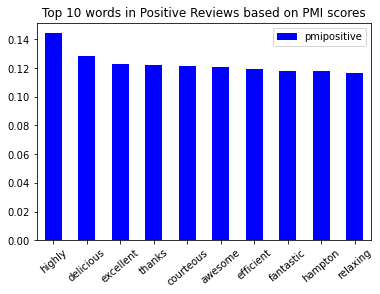

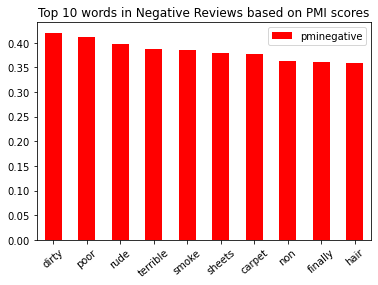

In [27]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

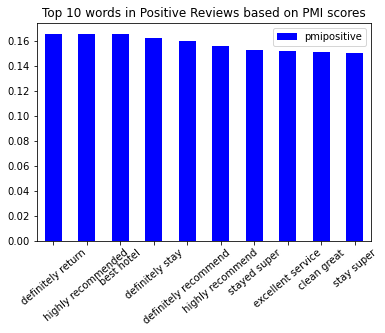

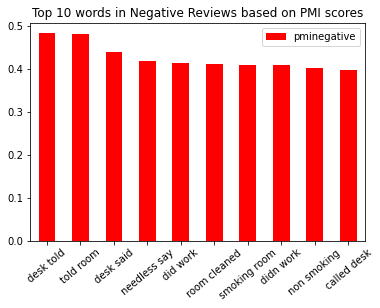

In [28]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

# Visualization
Sometimes, we can learn a lot about the data by visualizing.

## Historgrams

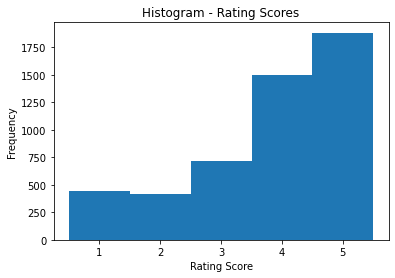

In [29]:
plt.xlabel('Rating Score')
hotelDf['ratingScore'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

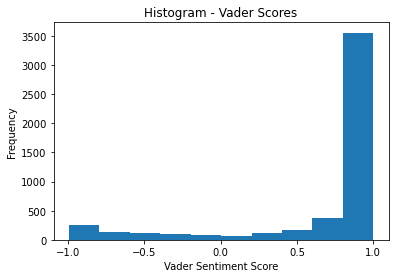

In [30]:
plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

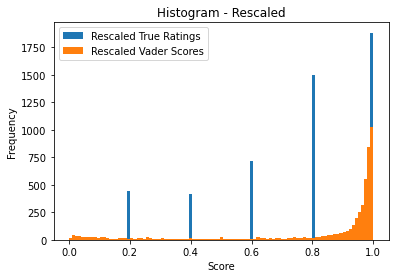

In [32]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['ratingScore'].to_numpy() / 5]
y = [(hotelDf['vaderScore'].to_numpy() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

## Boxplots

In [34]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ratingByHotel.sort_values('ratingScore', ascending=False).head(5).hotelName.to_numpy()

tempdf = hotelDf[(hotelDf.hotelName == tp5gthotel[0]) | (hotelDf.hotelName == tp5gthotel[1]) | 
         (hotelDf.hotelName == tp5gthotel[2]) | (hotelDf.hotelName == tp5gthotel[3]) | 
         (hotelDf.hotelName == tp5gthotel[4])]

C:\Users\Tru Projects\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Tru Projects\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


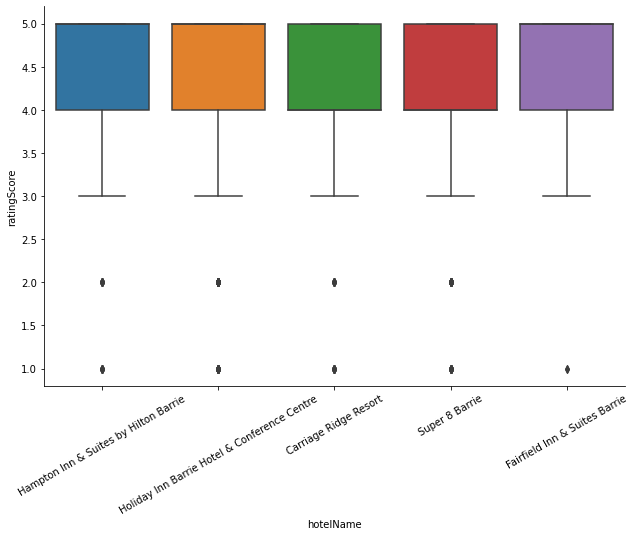

In [35]:
g = sns.factorplot(kind='box',        # Boxplot
               y='ratingScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

C:\Users\Tru Projects\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Tru Projects\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


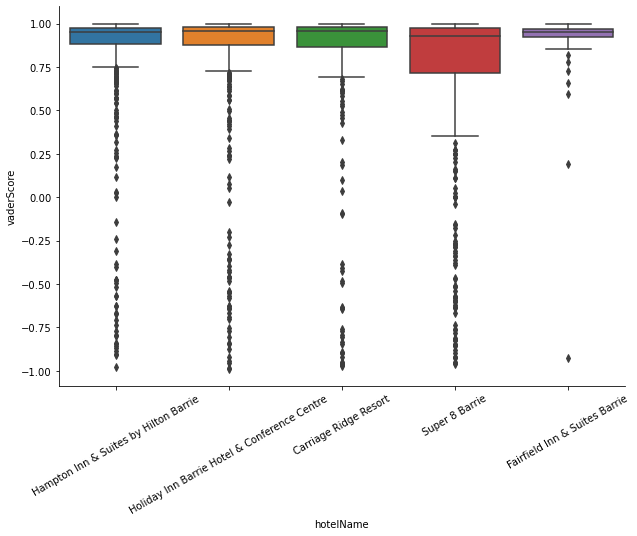

In [36]:
g = sns.factorplot(kind='box',        # Boxplot
               y='vaderScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

## Scatterplots

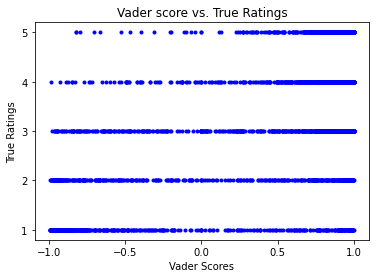

In [38]:
y = hotelDf['ratingScore'].to_numpy()
x = hotelDf['vaderScore'].to_numpy()
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()